In [1]:
import numpy as np
import pandas as pd
import os
import glob
import random
import string
from keras import Model
from keras.layers import Dropout, Flatten, Dense
from keras.src.applications import VGG16
from keras.utils import plot_model, set_random_seed
from keras.preprocessing.image import ImageDataGenerator

class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 30
    num_classes = 24
    img_channels = 3
    random_seed = 2501
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    set_random_seed(2501)
    


In [2]:
TRAIN_PATH = "/Users/teodorastereciu/PycharmProjects/mlp/data/asl_train/asl_alphabet_train"
labels = {i: letter for i, letter in enumerate(char for char in string.ascii_uppercase if char not in {'J', 'Z'})}
list_path = []
list_labels = []
for label in labels.values():
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [3]:
metadata

,image_path,label
0,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
1,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
2,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
3,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
4,/Users/teodorastereciu/PycharmProjects/mlp/dat...,A
...,...,...
71995,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
71996,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
71997,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
71998,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=CFG.random_seed, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=CFG.random_seed,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
52839,/Users/teodorastereciu/PycharmProjects/mlp/dat...,S
32099,/Users/teodorastereciu/PycharmProjects/mlp/dat...,L
18658,/Users/teodorastereciu/PycharmProjects/mlp/dat...,G
66927,/Users/teodorastereciu/PycharmProjects/mlp/dat...,X
8102,/Users/teodorastereciu/PycharmProjects/mlp/dat...,C
...,...,...
62814,/Users/teodorastereciu/PycharmProjects/mlp/dat...,V
69365,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
39832,/Users/teodorastereciu/PycharmProjects/mlp/dat...,O
15959,/Users/teodorastereciu/PycharmProjects/mlp/dat...,F


,image_path,label
54777,/Users/teodorastereciu/PycharmProjects/mlp/dat...,T
13186,/Users/teodorastereciu/PycharmProjects/mlp/dat...,E
39496,/Users/teodorastereciu/PycharmProjects/mlp/dat...,O
19755,/Users/teodorastereciu/PycharmProjects/mlp/dat...,G
31530,/Users/teodorastereciu/PycharmProjects/mlp/dat...,L
...,...,...
11002,/Users/teodorastereciu/PycharmProjects/mlp/dat...,D
20560,/Users/teodorastereciu/PycharmProjects/mlp/dat...,G
9856,/Users/teodorastereciu/PycharmProjects/mlp/dat...,D
25762,/Users/teodorastereciu/PycharmProjects/mlp/dat...,I


,image_path,label
71273,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
15415,/Users/teodorastereciu/PycharmProjects/mlp/dat...,F
34459,/Users/teodorastereciu/PycharmProjects/mlp/dat...,M
49214,/Users/teodorastereciu/PycharmProjects/mlp/dat...,R
23739,/Users/teodorastereciu/PycharmProjects/mlp/dat...,H
...,...,...
12884,/Users/teodorastereciu/PycharmProjects/mlp/dat...,E
70944,/Users/teodorastereciu/PycharmProjects/mlp/dat...,Y
20325,/Users/teodorastereciu/PycharmProjects/mlp/dat...,G
30530,/Users/teodorastereciu/PycharmProjects/mlp/dat...,L


In [7]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(
        rescale=1/255.,
    )
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
        color_mode='grayscale',
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
        color_mode='grayscale',
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        color_mode='grayscale',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [12]:
seed_everything(CFG.random_seed)
train_generator, validation_generator, test_generator = data_augmentation()

Found 48085 validated image filenames belonging to 24 classes.
Found 13115 validated image filenames belonging to 24 classes.
Found 10800 validated image filenames belonging to 24 classes.


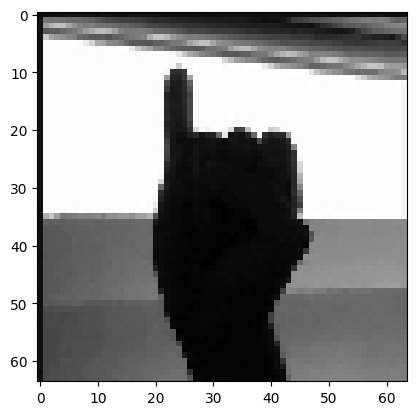

In [11]:
#import matplotlib.pyplot as plt
#images, labels = next(train_generator)

#plt.imshow(images[0], cmap='gray')
#plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                        

None

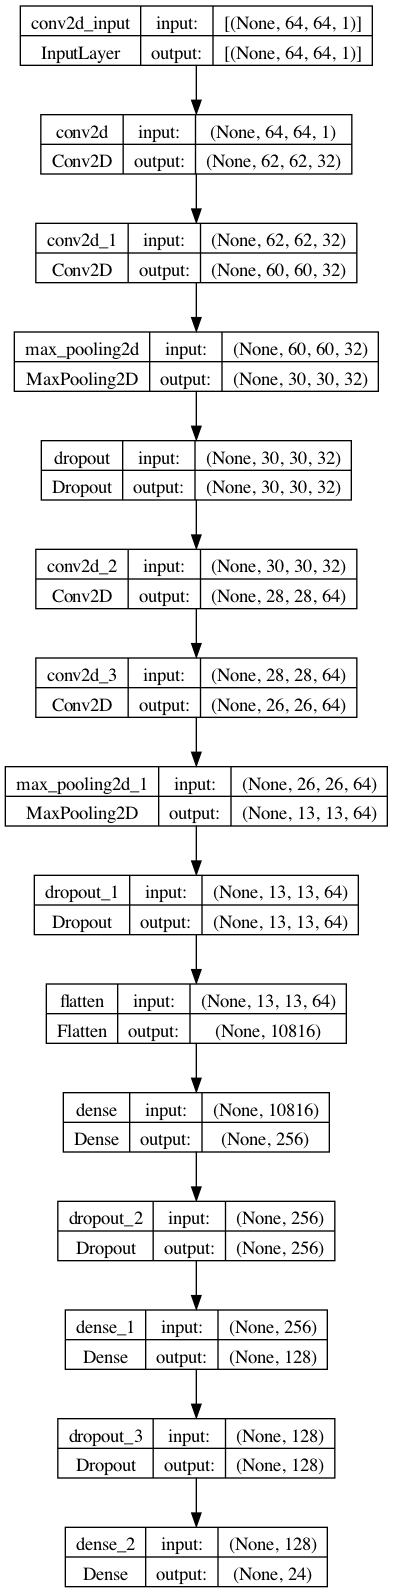

In [13]:
from keras.src.layers import Convolution2D, MaxPooling2D
from keras import Sequential

model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(CFG.img_width, CFG.img_height, 1)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(24, activation='softmax'))

display(model.summary())
display(plot_model(model, to_file='our_model.png', show_shapes=True))

In [14]:
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('final.h5', save_best_only=True, monitor='val_accuracy', mode='max')
es = EarlyStopping(monitor='val_loss', patience=4)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint, es]
)

Epoch 1/30
751/751 [==============================] - 167s 221ms/step - loss: 2.2465 - accuracy: 0.2964 - val_loss: 0.6923 - val_accuracy: 0.8030
Epoch 2/30


/Users/teodorastereciu/anaconda3/envs/mlplsss/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


751/751 [==============================] - 173s 230ms/step - loss: 0.7437 - accuracy: 0.7440 - val_loss: 0.2064 - val_accuracy: 0.9462
Epoch 3/30
751/751 [==============================] - 177s 235ms/step - loss: 0.4139 - accuracy: 0.8580 - val_loss: 0.0986 - val_accuracy: 0.9758
Epoch 4/30
751/751 [==============================] - 180s 239ms/step - loss: 0.2895 - accuracy: 0.9025 - val_loss: 0.1066 - val_accuracy: 0.9655
Epoch 5/30
751/751 [==============================] - 186s 247ms/step - loss: 0.2251 - accuracy: 0.9232 - val_loss: 0.0416 - val_accuracy: 0.9881
Epoch 6/30
751/751 [==============================] - 191s 254ms/step - loss: 0.1817 - accuracy: 0.9398 - val_loss: 0.0285 - val_accuracy: 0.9929
Epoch 7/30
751/751 [==============================] - 213s 283ms/step - loss: 0.1535 - accuracy: 0.9505 - val_loss: 0.0253 - val_accuracy: 0.9923
Epoch 8/30
751/751 [==============================] - 222s 295ms/step - loss: 0.1349 - accuracy: 0.9564 - val_loss: 0.0192 - val_accura

In [16]:
import pickle

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

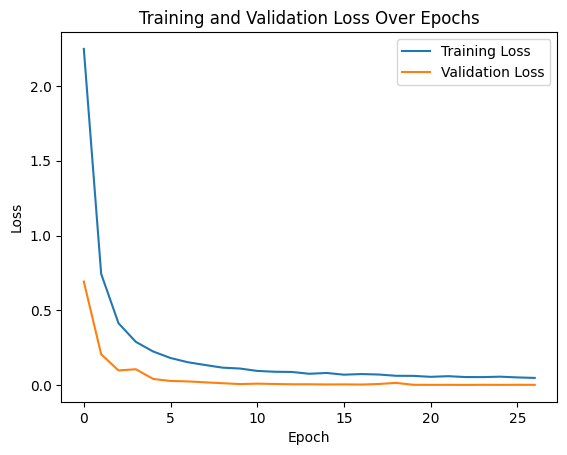

In [18]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [20]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

/var/folders/x1/dl1z_tcs7zb6pppfbf65d5sh0000gn/T/ipykernel_39917/945805665.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_generator))


Test Accuracy: 99.89%


In [21]:
print(f'Test Loss: {test_loss}%')

Test Loss: 0.0026863794773817062%
